# Poisson-BVP-1

This notebook implements the BCGP experiments for Poisson-BVP-1 from Section 5.2.1 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ['JAX_PLATFORM_NAME'] = 'cpu'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [2]:
import jax.numpy as jnp
from jax import config, random, devices

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append('../../')

import jax_pigp
from jax_pigp.utility_fns import softplus, generate_params
from jax_pigp.base import Callable, Array

from utility_fns import *
from utility_fns import PARAM_OPTIONS_DICT as param_gen_options

# double precision prevents nans
config.update("jax_enable_x64", True) 
# config.update("jax_debug_nans", True) 

Check what devices are available

In [3]:
devices()

[CudaDevice(id=0)]

### Specify settings of the experiments

In [4]:
# set value of true function u and pde function f
u: Callable = lambda x: x**2
f: Callable = lambda x: 0.*x - 2.

# set domain bounds
LOWER_VAL: int = 0.
UPPER_VAL: int = 2.

# base random seed for parameter initialisation
BASE_SEED_VAL: int = 117

# only BCGP supported for this example
GP_TYPE: str = 'bcgp'
assert GP_TYPE in ['bcgp']

# number of PDE (i.e. f-space) collocation points to use for inference
Nf: int = 4

# number of test points to consider
Ns = 100

# dimensionality of the spatial domain
INPUT_DIM: int = 1

# initial value for std of noise level in f-space
NOISE_INIT = jnp.array([0.1])

# softplus transformation ensures noise and theta values are positive
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = True

# options for model training
N_TRAIN_STEPS: int = 30000
N_RESTARTS: int    = 1
LR_INIT: float     = 0.025
VERBOSE: bool      = True

### Specify boundary-constrained mean and kernel functions

The BCGP mean and kernel functions are presented in Appendix B.2.1 of the manuscript, and they are designed to ensure that the BCGP exactly satisfies the Dirichlet condition at $x=0$ and the Robin condition at $x=2$. 

The mean function is simply set to zero 

In [5]:
mean_fn = lambda p, x: x[0]*0.

The kernel $\tilde{k}(x, x')$ takes the form

\begin{equation*}
	\tilde{k}(x,x') = \mathcal{B}^{m_1}_{x} \mathcal{B}^{m_1}_{x'} k_1(x,x') + \mathcal{B}^{m_2}_{x} \mathcal{B}^{m_2}_{x'} k_2(x,x') ,
\end{equation*}
in which $k_1$ and $k_2$ are squared-exponential kernels:

In [6]:
BASE_KERNEL = jax_pigp.kernels.squared_exponential

$\mathcal{B}^{m_1}_{x}$ and $\mathcal{B}^{m_2}_{x}$ are given by
\begin{align*}  
    \mathcal{B}^{m_1}_{x}[\cdot](x) &= \left(\phi_1(x) - \phi(x) \left[ \phi_1(x) + \nabla \phi_2(x) \cdot \nabla \phi_1(x) \right] \right)[\cdot](x) \notag \\
& - \phi(x) \phi_1(x) \nabla \phi_2(x) \cdot \nabla [\cdot](x), \notag \\ %.
    \mathcal{B}^{m_2}_{x}[\cdot](x) &= \phi(x) \phi_2(x) [\cdot](x). \notag
\end{align*}


The ADFs $\phi_1$, $\phi_2$, $\phi$ and their gradients have the form

In [7]:
def phi1(loc: Array):
    return loc[0]

def grad_phi1(loc: Array):
    return 1.

def phi2(loc: Array):
    return 2. - loc[0]

def grad_phi2(loc: Array):
    return -1.

# this is the R-equivalance join from Eq.(25) of the manuscript, expressed in slightly different form
def phi(loc: Array):
    phi_vals = jnp.array([phi1(loc), phi2(loc)])
    phi_sum = jnp.sum(phi_vals)
    return jnp.prod(phi_vals) / phi_sum

$\mathcal{B}^{m_1}_{x}$ and $\mathcal{B}^{m_2}_{x}$ can then be implemented as follows:

In [8]:
def apply_B1(fn: Callable, argnum: int = 1):

    # the Jacobian function
    Jfn, _ = jac_hess(fn, argnum)

    def B1(params: dict, loc1: Array, *loc2: Array):
        
        fn_val = fn(params, loc1, *loc2)
        # in 1D case the Jacobian is simply the derivative
        J_val = Jfn(params, loc1, *loc2)
        
        loc = loc1 if argnum == 1 else loc2[0]
    
        phi1_val = phi1(loc)
        phi2_val = phi2(loc)
        gradphi1_val = grad_phi1(loc)
        gradphi2_val = grad_phi2(loc)
    
        phi_val = phi(loc)

        # temporary values in line with the form of B1 given above
        tmp1 = (1. - phi_val)*phi1_val*fn_val
        tmp2 = (gradphi2_val*gradphi1_val)*fn_val
        tmp3 = (gradphi2_val*J_val).sum()*phi1_val
    
        return (tmp1 - phi_val*(tmp2 + tmp3)).squeeze()
        
    return B1

def B2(loc):
    return phi(loc)*phi2(loc)

And finally $\tilde{k}$ can be defined

In [9]:
def get_kernel_fn(base_kernel):

    Bm1_k1 = apply_B1(apply_B1(base_kernel, 1), 2) 
    k2 = base_kernel

    def bcgp_kernel(params: dict, loc1: Array, loc2: Array):

        k1_params = params['kernel_params_1']
        k2_params = params['kernel_params_2']

        Bm1_k1_val = Bm1_k1(k1_params, loc1, loc2)
        Bm2_k2_val = B2(loc1)*B2(loc2)*k2(k2_params, loc1, loc2)
        
        return Bm1_k1_val + Bm2_k2_val

    return bcgp_kernel

kernel_fn = get_kernel_fn(BASE_KERNEL)

### Specify Poisson differential operator

Recall that Poisson's equation over one spatial dimension takes the form

$$\mathcal{L}_{x}[u] =   -\frac{\partial^2 u}{\partial x^2} = f = 2.$$

##### Implementation: 

* $f$ is returned by calling the ``apply_PDE`` function defined below


In [10]:
def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the Poisson PDE to given input
    fn, evaluated at specified argnum
    """

    # the Hessian function
    _, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):

        # in 1D case the Hessian matrix is the second spatial derivative
        uxx_val = Hfn(params, loc1, *loc2)[0,0]
        
        return -uxx_val 
        
    return PDE 

linear_operators = [apply_PDE]

### Store settings

Store optimisation options in a dictionary

In [11]:
opt_options = {}
opt_options['n_steps']         = N_TRAIN_STEPS 
opt_options['n_restarts']      = N_RESTARTS
opt_options['lr']              = LR_INIT
opt_options['verbose']         = VERBOSE
opt_options['noise_transform'] = NOISE_TRANSFORM

Specify parameter initialisation function

In [12]:
param_gen_options['n_sub_kernels']   = 2
param_gen_options['input_dim']       = [INPUT_DIM]*param_gen_options['n_sub_kernels']   
param_gen_options['noise_std_init']  = NOISE_INIT
param_gen_options['noise_transform'] = NOISE_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [13]:
results_save_dir = f'results/poissonBVP1/{GP_TYPE}_Nf_{Nf}'
if not os.path.isdir(results_save_dir): 
    os.makedirs(results_save_dir)

## Data and model initialisation

#### Create train and test data

In [14]:
# create training data of PDE (i.e. f) collocation points
Xf = (jnp.linspace(LOWER_VAL, UPPER_VAL, Nf+2)[1:-1]).reshape(-1,1)
yf = f(Xf)
train_data = jax_pigp.datasets.TrainDataLinearPDE([Xf], [yf])

# create test data using true solution function (i.e. u)
Xs = jnp.linspace(LOWER_VAL, UPPER_VAL, Ns).reshape(-1,1)
us = u(Xs)
test_data = jax_pigp.datasets.TestData(Xs, us)

Check shapes of train and test data

In [15]:
train_data.ytrain.shape, [X.shape for X in train_data.Xtrain], test_data.Xs.shape, test_data.us.shape

((4, 1), [(4, 1)], (100, 1), (100, 1))

#### Initialise PIGP model

In [16]:
poisson_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(kernel_fn, linear_operators)
poisson_mean_fns   = jax_pigp.interdomain_moments.InterdomainMeanFns(mean_fn,     linear_operators)

gp_model = jax_pigp.models.GPR(poisson_kernel_fns, poisson_mean_fns, nugget=0.)

#### Initialise learner for model training

In [17]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)    

gp_learner = jax_pigp.optimisers.AdamLearner(obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL))

Initial parameter values  

In [18]:
print_param_values(gp_learner.params, opt_options)

kernel_params_1
amp: [22.28726652]
ls: [2.21816768]
alpha: [16.21577173]

kernel_params_2
amp: [23.59398771]
ls: [3.00901438]
alpha: [11.87336545]

noise_std: [0.1]


Objective function value for initial parameters

In [19]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(-10.59110366, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [20]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(10.59110366, dtype=float64),
 {'kernel_params_1': {'alpha': Array([0.], dtype=float64),
   'amp': Array([0.05457813], dtype=float64),
   'ls': Array([-1.47888088], dtype=float64)},
  'kernel_params_2': {'alpha': Array([0.], dtype=float64),
   'amp': Array([0.0244033], dtype=float64),
   'ls': Array([-0.1338386], dtype=float64)},
  'noise_std': Array([0.0096984], dtype=float64)})

### Plot samples from prior Gaussian process

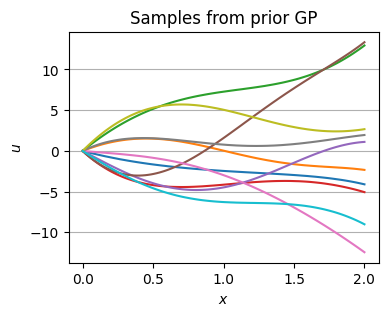

In [21]:
# prior mean and covariance over the test data
ms  = poisson_mean_fns.get_ms(gp_learner.params, test_data.Xs)[:,0]
nugget = 0.000001
Kss = poisson_kernel_fns.get_Kss(gp_learner.params, test_data.Xs) + jnp.eye(test_data.Xs.shape[0])*nugget

# generate samples
n_samp = 10
samples = random.multivariate_normal(random.PRNGKey(101), ms, Kss, shape=(n_samp,))

# plot samples
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ONE_COLUMN_FIGSIZE)

ax.plot(Xs, samples[:n_samp].T);

ax.yaxis.grid(True)

ax.set_ylabel(r'$u$')
ax.set_xlabel(r'$x$')

ax.set_title('Samples from prior GP')

plt.show()

## Training 

[JIT compile](https://jax.readthedocs.io/en/latest/jit-compilation.html) the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [22]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [23]:
print(f'gp_type={GP_TYPE}, Nf={Nf}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n')
gp_learner.train_with_restarts(opt_options['n_steps'], 
                               opt_options['n_restarts'], 
                               print_progress = opt_options['verbose'])

gp_type=bcgp, Nf=4, n_steps=30000, n_restarts=1

Restart 0: beginning training for 30000 steps
(0): 10.5546, noise_std_vals = [9.76e-02]
(1200): 1.0847, noise_std_vals = [4.35e-05]
(2400): -0.6188, noise_std_vals = [7.54e-06]
(3600): -1.7813, noise_std_vals = [2.23e-06]
(4800): -2.7202, noise_std_vals = [8.11e-07]
(6000): -3.5261, noise_std_vals = [3.31e-07]
(7200): -4.2321, noise_std_vals = [1.45e-07]
(8400): -4.8533, noise_std_vals = [6.78e-08]
(9600): -5.4003, noise_std_vals = [3.33e-08]
(10800): -5.8833, noise_std_vals = [1.72e-08]
(12000): -6.3118, noise_std_vals = [9.19e-09]
(13200): -6.6948, noise_std_vals = [5.10e-09]
(14400): -7.0394, noise_std_vals = [2.92e-09]
(15600): -7.3519, noise_std_vals = [1.71e-09]
(16800): -7.6373, noise_std_vals = [1.03e-09]
(18000): -7.8995, noise_std_vals = [6.30e-10]
(19200): -8.1418, noise_std_vals = [3.94e-10]
(20400): -8.3669, noise_std_vals = [2.52e-10]
(21600): -8.5770, noise_std_vals = [1.66e-10]
(22800): -8.7411, noise_std_vals = [1.20e-10

Uncomment below to continue training from existing parameter values:

In [30]:
# gp_learner.train(opt_options["n_steps"])
# gp_learner.params_best = gp_learner.params.copy()

### Plot training results

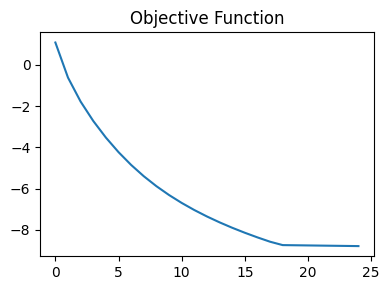

In [25]:
theta_arr = jnp.array(gp_learner.theta_list)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ONE_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list)*0.05)

plot_lc(ax, gp_learner.obj_list[begin_at:], 'Objective Function')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'learningCurves.pdf'))

### Final trained parameter values

In [26]:
# extract final trained parameter values
trained_params = gp_learner.params_best.copy()

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'wb') as fp:
    pickle.dump(trained_params, fp)

kernel_params_1
alpha: [5.50236516]
amp: [1.86243193]
ls: [424.86120672]

kernel_params_2
alpha: [19.1375392]
amp: [2.24681416]
ls: [516.25128519]

noise_std: [1.00653486e-10]


Can load pre-trained parameters by uncommenting the below

In [27]:
# with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [28]:
# posterior mean and covariance over test points
print(f'Posterior results for {GP_TYPE}, Nf={train_data.Xtrain[0].shape[0]}, Ns={test_data.Xs.shape[0]}')
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, 'u_pred.npy'), mu)
    jnp.save(os.path.join(results_save_dir, 'Xs.npy'), test_data.Xs)
    jnp.save(os.path.join(results_save_dir, 'us.npy'), test_data.us)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f'mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}')
savetxt(os.path.join(results_save_dir, 'mean_loss.txt'), abs_losses.mean().reshape(-1,1))

Posterior results for bcgp, Nf=4, Ns=100
mean/max loss: 3.999445e-11/9.699e-11


### Plots of posterior prediction

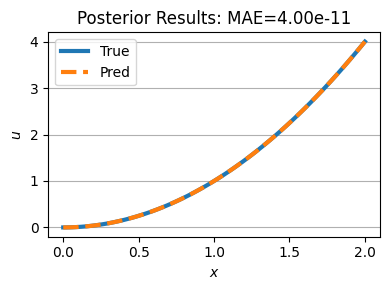

In [29]:
# plot samples
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ONE_COLUMN_FIGSIZE)

ax.plot(test_data.Xs, test_data.us, label="True", lw=3);
ax.plot(test_data.Xs, mu, '--', label="Pred", lw=3);

ax.yaxis.grid(True)

ax.set_ylabel(r'$u$')
ax.set_xlabel(r'$x$')

ax.set_title(f'Posterior Results: MAE={abs_losses.mean():.2e}')
ax.legend()

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'posteriorPrediction.pdf'))